In [363]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from joblib import parallel_backend, Parallel, delayed
num_cores = 10
import time

from scipy.integrate import odeint
from scipy.integrate import simps
from scipy.optimize import minimize

import seaborn as sns
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib import colors
import matplotlib as mpl

import pickle

import time
import copy

import os

import importlib

In [364]:
from ionization import Transmon_Module as TM
from ionization import branch_analysis as BA
from ionization import floquet_analysis as FA

importlib.reload(FA)
importlib.reload(BA)



<module 'ionization.branch_analysis' from '/Users/dumm3209/Desktop/Codes/VScode/ionization/ionization/branch_analysis.py'>

In [207]:
import sys
sys.path.insert(1, "/Users/dumm3209/Desktop/Codes/VScode/PrettyPlots")
import pretty_plots 
list_colors = pretty_plots.list_colors

In [3]:
GHz,MHz,kHz = 2*np.pi,2*np.pi*1e-3,2*np.pi*1e-6
ns,us,ms = 1,1e3,1e6

# Transmon

In [ ]:
# PARAMÈTRES DIAGONALISATION 
max_charge = 200
n_trunc = 31
max_fock = 10

# physical parameters, Hassani no EL
E_J = 29.93 * GHz
E_C = 0.164 * GHz
E_L = 0 * GHz
type_qubit = "Transmon"

phi_ext = np.pi * 0
n_g = 0

g = 100 * MHz
omega_r = 6 * GHz
omega_d = omega_r

#Floquet
max_fock_floquet = 500
eps_d_step = 10 * MHz
eps_d_max = 2 * g * np.sqrt(max_fock_floquet)
eps_d_vec = np.arange(0,eps_d_max,eps_d_step)
N_times = 1
N_periods = 1
phi = 0

6.097812646301949
6.097812646301696


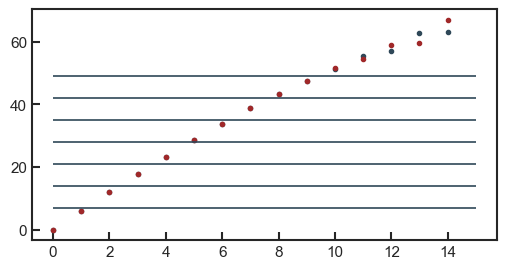

In [17]:
for n_g in [0,0.5]:
    
    Transmon_params = {'E_J':E_J,'phi_ext':phi_ext,'E_C':E_C,'g':g,'omega_r':omega_r,'max_charge':max_charge,'max_fock':max_fock,'n_trunc':n_trunc,'n_g':n_g}
    transmon_cavity = TM.Transmon_Cavity(Transmon_params)

    transmon = transmon_cavity.Transmon
    eigs_t = transmon.E
    eigv_t = transmon.Eigvecs
    H_t = transmon.H_t_eigbasis  # Hamiltonien diagonal
    I_t = transmon.I_t
    n_t = transmon.n_t_eigbasis  # charge operator in transmon eigenbasis
    omega_q = transmon.omega_q
    print(omega_q/GHz)

    plt.plot((eigs_t[0:15]-np.min(eigs_t))/GHz,'.')

for i in range(1,8):
    plt.hlines(i*omega_d/GHz,0,15)


In [ ]:

for index_n_g,n_g in enumerate(np.array([0,0.5])):

    Transmon_params = {'E_J':E_J,'phi_ext':phi_ext,'E_C':E_C,'g':g,'omega_r':omega_r,'max_charge':max_charge,'max_fock':max_fock,'n_trunc':n_trunc,'n_g':n_g}
    transmon_cavity = TM.Transmon_Cavity(Transmon_params)

    transmon = transmon_cavity.Transmon
    eigs_t = transmon.E
    eigv_t = transmon.Eigvecs
    H_t = transmon.H_t_eigbasis  # Hamiltonien diagonal
    I_t = transmon.I_t
    n_t = transmon.n_t_eigbasis  # charge operator in transmon eigenbasis
    omega_q = transmon.omega_q

    # FLOQUET : generate and track
    Floquet_params = {'n_t':n_t,'I_t':I_t,'H_t':H_t,'n_g':n_g,'num_cores':5,'omega_d':omega_d,'phi':phi,'eps_d_vec':eps_d_vec,'N_times':N_times,'N_periods':N_periods}

    index_FA,f_energies,f_modes_0 = FA.generate_FA(Floquet_params,verbose=0)

    overlap_max,f_modes_0_sorted,f_energies_sorted,index_Floquet = FA.track(n_trunc,f_energies,f_modes_0,Floquet_params,Transmon_params,eigs_t)
    Floquet_params = {'n_t':n_t,'I_t':I_t,'H_t':H_t,'n_g':n_g,'num_cores':5,'omega_d':omega_d,'phi':phi,'eps_d_vec':eps_d_vec,'N_times':N_times,'N_periods':N_periods}

    index_FA,f_energies,f_modes_0 = FA.generate_FA(Floquet_params,verbose=0)

    overlap_max,f_modes_0_sorted,f_energies_sorted,index_Floquet = FA.track(n_trunc,f_energies,f_modes_0,Floquet_params,Transmon_params,eigs_t)


    ########### Find Floquet resonances with overlap ############
    N_t_sorted=[]
    for q in range(n_trunc):
        N_t_q_sorted=[]
        for i in range(len(eps_d_vec)):
            N_t_q_sorted.append(FA.N_t(f_modes_0_sorted[q][i],Transmon_params))    
        N_t_sorted.append(np.array(N_t_q_sorted))


    lwidth=1.7
    plt.figure(2*index_n_g,figsize=(5,2))

    for q in range(n_trunc):
        if q>1 and q!=11 and q!=5 and q!=13:
            plt.plot((eps_d_vec/2/g)**2,N_t_sorted[q],c='grey',alpha=0.5)
        else:
            plt.plot((eps_d_vec/2/g)**2,N_t_sorted[q],linewidth=lwidth,label='$i_t=0_t$')

    legend_elements = [mpl.lines.Line2D([0], [0], c=list_colors[0], ls='-',lw=lwidth, label=r'$0_t$'),
                    mpl.lines.Line2D([0], [0], c=list_colors[1], ls='-',lw=lwidth, label=r'$1_t$'),
                    mpl.lines.Line2D([0], [0], c=list_colors[2], ls='-',lw=lwidth, label=r'$5_t$'),
                    mpl.lines.Line2D([0], [0], c=list_colors[3], ls='-',lw=lwidth, label=r'$11_t$'),
                    mpl.lines.Line2D([0], [0], c=list_colors[4], ls='-',lw=lwidth, label=r'$13_t$')]


    plt.legend(handles=legend_elements, loc=(0,0.98),  ncol=5,columnspacing=1.02, frameon=False)

    plt.ylim(-0.8,n_trunc)
    plt.xlim(0,200)

    plt.ylabel('$N_t$',labelpad=-1)
    #plt.savefig('Floquet_BA.pdf',transparent=True)

    plt.figure(2*index_n_g+1,figsize=(5,2))

    i_cut=391
    for q in range(n_trunc):
        if q==3:
            plt.plot((eps_d_vec[:i_cut]/2/g)**2,np.array(f_energies_sorted[q][:i_cut])/GHz,c='grey',alpha=0.5)
            plt.plot((eps_d_vec[i_cut:]/2/g)**2,np.array(f_energies_sorted[q][i_cut:])/GHz,c='grey',alpha=0.5)

        elif q>1 and q!=11 and q!=5 and q!=13:
            plt.plot((eps_d_vec/2/g)**2,np.array(f_energies_sorted[q])/GHz,c='grey',alpha=0.5)
        else:
            plt.plot((eps_d_vec/2/g)**2,np.array(f_energies_sorted[q])/GHz,linewidth=2)

    plt.xlabel(r'$\overline{n}_r=(\varepsilon_t/2g)^2$',labelpad=0)
    plt.ylabel(r'$\varepsilon_{i_t}/2\pi$ [GHz]',labelpad=-2)
    #plt.xlim(0,200)
    plt.ylim(-omega_d/2/GHz,omega_d/2/GHz)

    #plt.savefig('Floquet_quasi.pdf',transparent=True, bbox_inches='tight')

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
Traceback (most recent call last):
  File "/Users/dumm3209/opt/anaconda3/envs/accelerate/lib/python3.11/site-packages/qutip/solver/integrator/scipy_integrator.py", line 63, in _mul_np_vec
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
Traceback (most recent call last):
  File "/Users/dumm3209/opt/anaconda3/envs/accelerate/lib/python3.11/site-packages/qutip/solver/integrator/scipy_integrator.py", line 69, in _mul_np_vec
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLo

# IST

In [564]:
# PARAMÈTRES DIAGONALISATION 
max_charge = 200
n_trunc = 31
max_fock = 10

# # Xander parameter
# E_J = 4.45 * GHz
# E_L = 4.44 * GHz
# E_C = 1 * GHz
# type_qubit = "L_shunt"

# # physical parameters, Hassani
# E_J = 29.93 * GHz
# E_C = 0.164 * GHz
# E_L = 0.56 * GHz
# type_qubit = "L_shunt"
# print(E_L/E_J)
# print(E_L/E_C)

# # physical parameters, Hassani no EL
# E_J = 29.93 * GHz
# E_C = 0.164 * GHz
# E_L = 0 * GHz
# type_qubit = "Transmon"
# print(E_L/E_J)
# print(E_L/E_C)

# # physical parameters, Kalacheva A III
# E_J = 4 * GHz
# E_C = 1.5 * GHz
# E_L = 7.4 * GHz
# type_qubit = "L_shunt"
# print(E_L/E_J)
# print(E_L/E_C)

# # # physical parameters, Kalacheva B 
# E_J = 8.61 * GHz
# E_C = 0.47 * GHz
# E_L = 8.11 * GHz
# type_qubit = "L_shunt"
# print(E_L/E_J)
# print(E_L/E_C)

# # Fasciati
# E_J = 14.9 * GHz
# E_C = 0.245 * GHz
# E_L = 22.2 * GHz
# type_qubit = "L_shunt"
# print(E_L/E_J)
# print(E_L/E_C)

# Valla Fatemi
E_J = 0.1 * GHz
E_C = E_J * 5
E_L = E_J
type_qubit = "L_shunt"

print(E_L/E_J)
print(E_L/E_C)

print(E_J/GHz)
print(E_L/GHz)
print(E_C/GHz)

phi_ext = np.pi * 0
n_g = 0

g = 100 * MHz
omega_r = 6 * GHz
omega_d = omega_r

#Floquet
max_fock_floquet = 500
eps_d_step = 10 * MHz
eps_d_max = 2 * g * np.sqrt(max_fock_floquet)
eps_d_vec = np.arange(0,eps_d_max,eps_d_step)
N_times = 1
N_periods = 1
phi = 0

1.0
0.2
0.1
0.1
0.5


0.6324555320336759


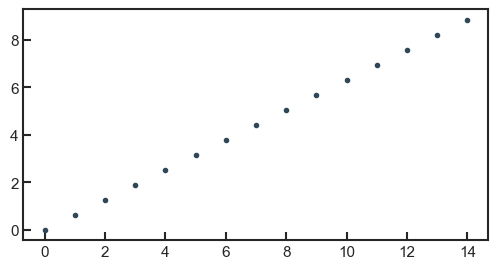

In [567]:
linear_res_params = {'E_J': 0,'E_L':E_L,'phi_ext':phi_ext,'E_C':E_C,'g':g,'omega_r':omega_r,'max_fock':max_fock,'n_trunc':n_trunc,'type':type_qubit}
linear_res_cavity = TM.Transmon_Cavity(linear_res_params)
linear_res = linear_res_cavity.Transmon

eigs_linear_res = linear_res.E - np.min(linear_res.E)

plt.plot((eigs_linear_res[0:15]-np.min(eigs_linear_res))/GHz,'.')

print(np.sqrt(8 * E_L * E_C) / GHz)

In [568]:
omega_linear = eigs_linear_res[1]
print(omega_linear / GHz)
print(np.sqrt(8 * E_L * E_C) / GHz)

0.632450531994134
0.6324555320336759


0.699074837845339


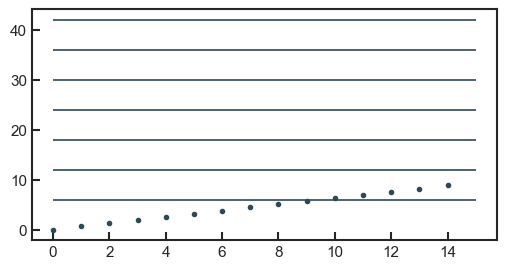

In [569]:
IST_params = {'E_J': E_J,'E_L': E_L,'phi_ext':phi_ext,'E_C':E_C,'g':g,'omega_r':omega_r,'max_fock':max_fock,'n_trunc':n_trunc,'type':type_qubit}
IST_cavity = TM.Transmon_Cavity(IST_params)

IST = IST_cavity.Transmon
eigs_t = IST.E
eigv_t = IST.Eigvecs
H_t = IST.H_t_eigbasis  # Hamiltonien diagonal
I_t = IST.I_t
n_t = IST.n_t_eigbasis  # charge operator in transmon eigenbasis
omega_q = IST.omega_q
evecs = IST.Eigvecs
print(omega_q/GHz)

plt.plot((eigs_t[0:15]-np.min(eigs_t))/GHz,'.')

for i in range(1,8):
    plt.hlines(i*omega_d/GHz,0,15)

phi_vec = IST.phi_vec


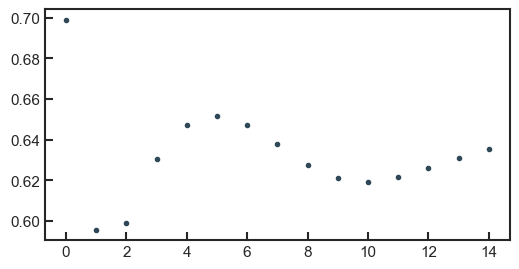

In [570]:
plt.plot((eigs_t[1:16]-eigs_t[0:15])/GHz,'.')

In [571]:
omega_12 = (eigs_t[2]-eigs_t[1])
alpha = omega_12 - omega_q

print(omega_q/GHz)
print(omega_12/GHz)
print(alpha/GHz)

0.699074837845339
0.5957787896102458
-0.1032960482350932


In [572]:
print((eigs_t[2]-eigs_t[1] - omega_q)/MHz)

-103.2960482350932


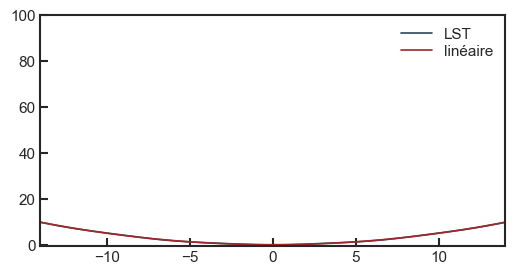

In [573]:
plt.plot(phi_vec, (-E_J*np.cos(phi_vec) + E_L/2 *(phi_vec + phi_ext)**2)/GHz, label = "LST")
plt.plot(phi_vec, (E_L/2 *(phi_vec + phi_ext)**2)/GHz, label = "linéaire")
plt.xlim(-14,14)
plt.ylim(-E_J,100)
plt.legend()

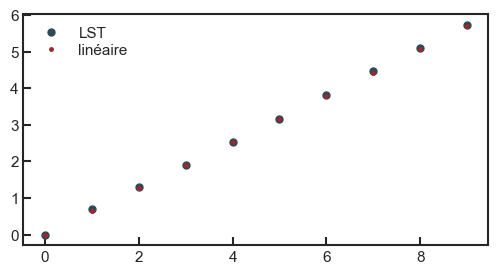

In [574]:
q_max = 10
plt.plot((eigs_t[:q_max]-eigs_t[0])/GHz,'.',markersize=10,label='LST')
plt.plot(eigs_linear_res[:q_max]/GHz,'.',markersize=5, label = "linéaire")
plt.legend()


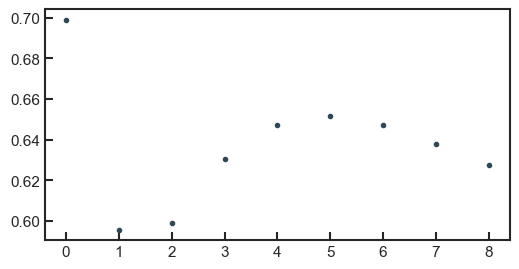

In [575]:
plt.plot((eigs_t[1:q_max]-eigs_t[:q_max-1])/GHz,'.')


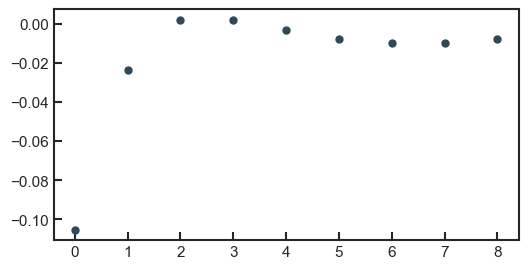

In [576]:
plt.plot((eigs_linear_res[1:q_max]-(eigs_t[1:q_max]-eigs_t[0]))/eigs_linear_res[1:q_max],'.',markersize=10,label='LST')


(-0.1, 10.0)

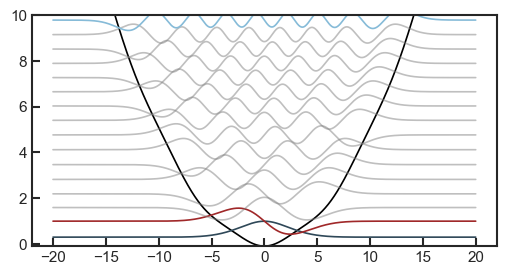

In [577]:
plt.plot(phi_vec, (-E_J*np.cos(phi_vec) + E_L/2 *(phi_vec + phi_ext)**2)/GHz, c="k")

for q in range(n_trunc):
    if q in [0,1,15,19]:
        plt.plot(phi_vec, eigs_t[q]/GHz + 0.1e2*np.real(evecs[q].full()))
    else:
        plt.plot(phi_vec, eigs_t[q]/GHz + 0.1e2*np.real(evecs[q].full()),c="grey",alpha=0.5)

plt.ylim(-E_J/GHz,100*E_J/GHz)

#plt.savefig('Fasciati')

(-1.2566370614359172, 1.8849555921538759)

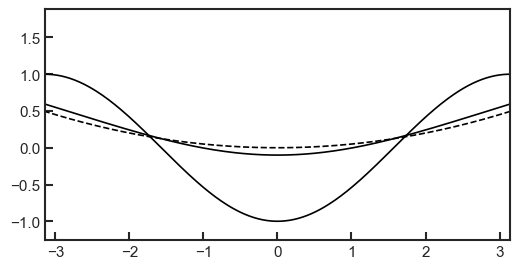

In [578]:
plt.plot(phi_vec, (-E_J*np.cos(phi_vec) + E_L/2 *(phi_vec-phi_ext)**2)/GHz, c="k")

plt.plot(phi_vec, 10*(-E_J*np.cos(phi_vec) )/GHz, c="k")

plt.plot(phi_vec, (E_L/2 *(phi_vec-phi_ext)**2)/GHz, c="k",linestyle='dashed')

plt.xlim(phi_ext-np.pi,phi_ext+np.pi)
plt.ylim(-2*E_J,3*E_J)

In [579]:
# FLOQUET : generate and track
n_g = 0
Floquet_params = {'n_t':n_t,'I_t':I_t,'H_t':H_t,'n_g':n_g,'num_cores':5,'omega_d':omega_d,'phi':phi,'eps_d_vec':eps_d_vec,'N_times':N_times,'N_periods':N_periods}

index_FA,f_energies,f_modes_0 = FA.generate_FA(Floquet_params,verbose=0)

overlap_max,f_modes_0_sorted,f_energies_sorted,index_Floquet = FA.track(n_trunc,f_energies,f_modes_0,Floquet_params,IST_params,eigs_t)

In [451]:
########### Find Floquet resonances with overlap ############
N_t_sorted=[]
for q in range(n_trunc):
    N_t_q_sorted=[]
    for i in range(len(eps_d_vec)):
        N_t_q_sorted.append(FA.N_t(f_modes_0_sorted[q][i],IST_params))    
    N_t_sorted.append(np.array(N_t_q_sorted))

Text(0, 0.5, '$N_t$')

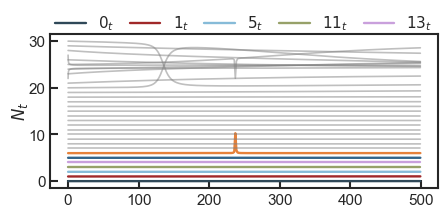

In [452]:
lwidth=1.7
plt.figure(figsize=(5,2))

for q in range(n_trunc):
    if q in [0,1,2,3,4,5,6]:
        plt.plot((eps_d_vec/2/g)**2,N_t_sorted[q],linewidth=lwidth,label='$i_t=0_t$')
    else:
        plt.plot((eps_d_vec/2/g)**2,N_t_sorted[q],c='grey',alpha=0.5)

legend_elements = [mpl.lines.Line2D([0], [0], c=list_colors[0], ls='-',lw=lwidth, label=r'$0_t$'),
                   mpl.lines.Line2D([0], [0], c=list_colors[1], ls='-',lw=lwidth, label=r'$1_t$'),
                   mpl.lines.Line2D([0], [0], c=list_colors[2], ls='-',lw=lwidth, label=r'$5_t$'),
                   mpl.lines.Line2D([0], [0], c=list_colors[3], ls='-',lw=lwidth, label=r'$11_t$'),
                   mpl.lines.Line2D([0], [0], c=list_colors[4], ls='-',lw=lwidth, label=r'$13_t$')]


plt.legend(handles=legend_elements, loc=(0,0.98),  ncol=5,columnspacing=1.02, frameon=False)

#plt.ylim(-0.8,15)
#plt.xlim(0,200)
plt.ylabel('$N_t$',labelpad=-1)
#plt.savefig('Floquet_BA.pdf',transparent=True)

In [549]:

def chi_i_numerics(i):
    
    index_1_photon = np.argmin(np.abs((eps_d_vec/2/g)**2 - 1))

    if np.abs((eps_d_vec[index_1_photon]/2/g)**2 - 1) > 0.001 :
        print('not good sampling of photon number')

    chi_i = f_energies_sorted[i][index_1_photon] - f_energies_sorted[i][0] 

    return chi_i

chi_0 = chi_i_numerics(0)

chi_1 = chi_i_numerics(1)

omega_r_0 = omega_r + chi_0

omega_r_1 = omega_r + chi_1

print((chi_0)/MHz)
print((chi_1)/MHz)

print((chi_1-chi_0)/MHz)

print(omega_r_0/GHz)
print(omega_r_1/GHz)

0.03188548632131033
0.016445161576968764
-0.015440324744341568
6.000031885486321
6.0000164451615765


In [550]:
g / (omega_q-omega_r)

np.float64(-0.019773650852187057)

In [ ]:
def chi_i_theo(i,omega_r=omega_r):
    
    chi_i = 0
    chi_i_j_all = []
    
    for j in range(n_trunc):
        omega_ij = eigs_t[j] - eigs_t[i]
        chi_i_j = 2 * g**2 * omega_ij * np.abs(n_t[i,j])**2 / (omega_r**2 - omega_ij**2)

        chi_i += chi_i_j
        chi_i_j_all.append(chi_i_j)

    return chi_i,np.array(chi_i_j_all)

chi_0,chi_0_j = chi_i_theo(0)
chi_1,chi_1_j = chi_i_theo(1)

print(chi_0/MHz)
print(chi_1/MHz)

print((chi_1-chi_0)/MHz)

0.031885778037329414
0.016443891481522796
-0.015441886555806621


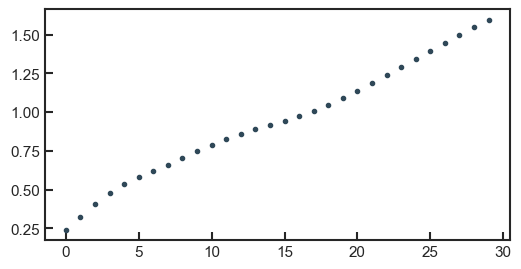

In [546]:

plt.plot(np.abs(np.diag(n_t[:,:],1)),'.')

In [554]:
omega_q/GHz

np.float64(0.9427649578965058)

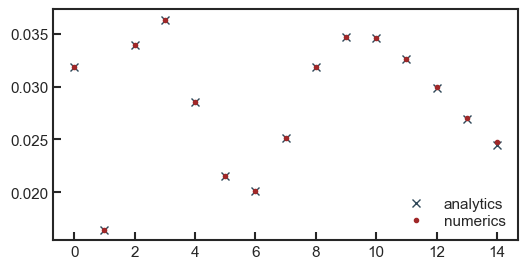

In [561]:
i_max = 15

chi_i_analytics_all = []
chi_i_j_analytics_all = []
for i in range(i_max):
    chi_i,chi_i_j = chi_i_theo(i)
    chi_i_analytics_all.append(chi_i)
    chi_i_j_analytics_all.append(chi_i_j)
chi_i_analytics_all = np.array(chi_i_analytics_all)
chi_i_j_analytics_all = np.array(chi_i_j_analytics_all)

plt.plot(chi_i_analytics_all/MHz,'x',label='analytics')


chi_i_numerics_all = []
for i in range(i_max):
    chi_i_numerics_all.append(chi_i_numerics(i))
chi_i_numerics_all = np.array(chi_i_numerics_all)

plt.plot(chi_i_numerics_all/MHz,'.',label='numerics')

plt.legend()

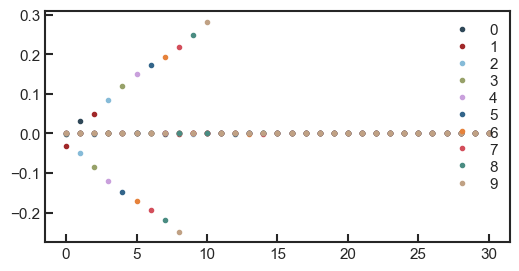

In [538]:
for i in range(10):
    plt.plot(chi_i_j_analytics_all[i]/MHz,'.',label = i)
plt.legend()

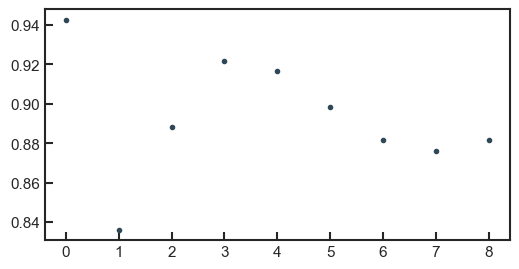

In [513]:
plt.plot((eigs_t[1:q_max]-eigs_t[:q_max-1])/GHz,'.')


In [462]:
omega_r/GHz

6.0

In [463]:
omega_q/GHz

np.float64(0.9427649578965058)

In [456]:
omega_r - omega_d

0.0

In [457]:
chi_0 / MHz

np.float64(0.03188754180562784)

In [458]:
chi_1 / MHz

np.float64(0.01651513268400054)

(-3.0, 3.0)

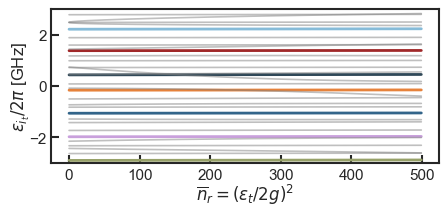

In [459]:
plt.figure(figsize=(5,2))

i_cut = 391
for q in range(n_trunc):
    if q in [0,1,2,3,4,5,6]:
        plt.plot((eps_d_vec/2/g)**2,np.array(f_energies_sorted[q])/GHz,linewidth=2)
    else:
        plt.plot((eps_d_vec/2/g)**2,np.array(f_energies_sorted[q])/GHz,c='grey',alpha=0.5)

plt.xlabel(r'$\overline{n}_r=(\varepsilon_t/2g)^2$',labelpad=0)
plt.ylabel(r'$\varepsilon_{i_t}/2\pi$ [GHz]',labelpad=-2)
#plt.xlim(0,200)
plt.ylim(-omega_d/2/GHz, omega_d/2/GHz)

#plt.savefig('Floquet_quasi.pdf',transparent=True, bbox_inches='tight')
# plt.xlim(0,1)
# plt.ylim(1.1,1.3)

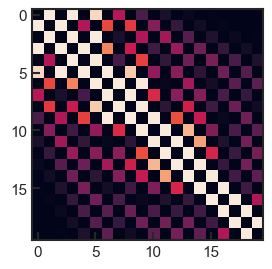

In [460]:
plt.imshow(np.abs(n_t.full()[0:20,0:20]), vmin=0, vmax = 0.01)

In [461]:
n_t

Quantum object: dims=[[31], [31]], shape=(31, 31), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.-1.80591155e-17j 0.-2.42471004e-01j 0.+3.10397946e-14j
  0.-1.74345258e-02j 0.+1.20162534e-13j 0.-9.49769936e-03j
  0.-2.21434654e-14j 0.-4.54844948e-03j 0.-7.17277671e-14j
  0.+1.92614521e-03j 0.+1.26836165e-13j 0.+7.07042773e-04j
  0.-1.45614608e-13j 0.-2.36110798e-04j 0.+1.28661692e-13j
  0.+8.08611876e-05j 0.-9.74086640e-14j 0.+3.24957710e-05j
  0.+6.62008523e-14j 0.+1.59176735e-05j 0.-4.03188460e-14j
  0.+8.63263441e-06j 0.+2.06820856e-14j 0.-4.53938952e-06j
  0.-7.87336868e-15j 0.+2.11867250e-06j 0.+2.53725323e-15j
  0.-8.44491797e-07j 0.-4.46863053e-15j 0.+2.87384110e-07j
  0.+1.12503482e-14j]
 [0.+2.42471004e-01j 0.-3.92727680e-17j 0.-3.23068364e-01j
  0.-1.25225033e-12j 0.-4.42528425e-03j 0.+7.67985881e-14j
  0.-6.15990339e-03j 0.+3.10419393e-13j 0.+5.85216314e-03j
  0.-3.09222551e-13j 0.-3.34648973e-03j 0.-1.80182018e-13j
  0.+1.40526985e-03j 0.+4.22063520e-14j 0.-4.698488

Questions :
- how feasible is this EJ, EL and EC ?
    - il faut EJ ~ EL et EC/EJ ~ 5-10
    - EC/EJ de cet order = charge qubit. maintenant, si on shunt avec EL, comment est-ce que la stray capacitance impacte C tot ?
- what would g be in that case ? then what would chi be ? i would take regular cavity, so need to figure out how g scales with E_C
    - g va dépendre de la matrice de capacitance et de l'impédance du résonateur.
- should we use a small omega_q with large omega_r, like in devoret paper ? or regular omega_q and omega_r values ?

regarder ce papier : https://arxiv.org/abs/2106.05882

transmon : g_theo = omega_r * C_g / C_sigma * (E_J/2/E_C)**(1/4) * np.sqrt(np.pi * Z_r / R_k)
fluxonium : ?

# BA

In [365]:
eigs_coupl = IST_cavity.eigs_coupl
eigv_coupl = IST_cavity.eigv_coupl

ind_tot,n_photon_tot,n_trans_tot,eigs_t_tot,branches_metrics,c_tot_norm = BA.generate_BA(eigv_coupl,eigs_coupl,max_fock,n_trunc)

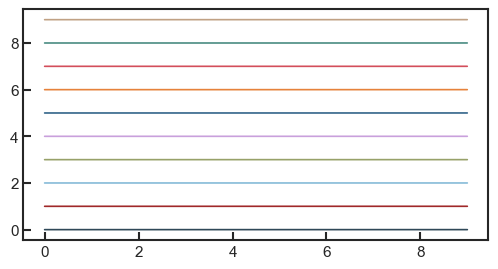

In [ ]:
for i in range(10):
    plt.plot(n_photon_tot[i],n_trans_tot[i])


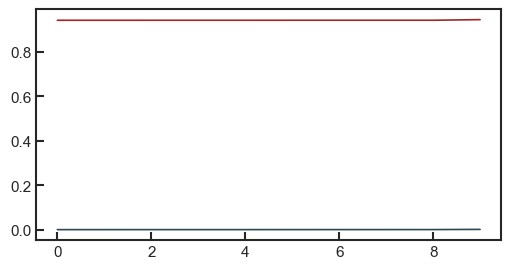

In [374]:
plt.figure(2)
for i in range(2):
    plt.plot(n_photon_tot[i],eigs_t_tot[i]%omega_r/GHz)

In [382]:
omega_r_0 = (eigs_t_tot[0,1]-eigs_t_tot[0,0])

omega_r_1 = (eigs_t_tot[1,1]-eigs_t_tot[1,0])

In [384]:
print((omega_r_0-omega_r)/MHz)

print((omega_r_1-omega_r)/MHz)

print((chi_1-chi_0)/MHz)

0.031883052055937354
0.0164331447953762
0.015372409121627299
